In [16]:
import pandas as pd
import time
import numpy as np
#from sklearn.cross_validation import train_test_split
import xgboost as xgb
import gc

In [17]:
# read_file
path = 'dataset/'
start_time = time.time()
train = pd.read_csv(path+"train.csv", skiprows=160000000, nrows=40000000)
test = pd.read_csv(path+"test.csv")
train.columns = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'attributed_time', 'is_attributed']
print('[{}] Finished loading data'.format(time.time() - start_time))
train.head()

[87.0449359417] Finished loading data


,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,11846,12,1,13,259,2017-11-09 08:17:26,NaN,0
1,5147,19,0,0,347,2017-11-09 08:17:26,NaN,0
2,11782,9,1,8,127,2017-11-09 08:17:26,NaN,0
3,33867,35,1,19,21,2017-11-09 08:17:26,2017-11-09 09:05:37,1
4,110589,3,1,23,280,2017-11-09 08:17:26,NaN,0


In [18]:
def dataPreProcessTime(df):
    df['datetime'] = pd.to_datetime(df['click_time'])
    #df['dow']      = df['datetime'].dt.dayofweek.astype(int)
    #df['month']    = df['datetime'].dt.month.astype(int)
    df['hour']     = df['datetime'].dt.hour.astype('uint8')
    #df['day']      = df['datetime'].dt.day.astype('uint8')
    #df.drop(['click_time','datetime'], axis=1, inplace=True)
    return df

# the single character 
def feature_ipcount(df):
    print("feature: ipcount ")
    ip_count = df.groupby(['ip'])['os'].count().reset_index()
    ip_count.columns = ['ip', 'ipcount']
    df = pd.merge(df, ip_count, on='ip', how='left', sort=False)
    del ip_count
    gc.collect()
    return df

def feature_appcount(df):
    print("feature: appcount")
    app_count = df.groupby(['app'])['os'].count().reset_index()
    app_count.columns = ['app','appcount']
    df = pd.merge(df, app_count, on='app', how='left', sort=False)
    del app_count
    gc.collect()
    return df

def feature_channelcount(df):
    print("feature: channelcount ")
    channel_count = df.groupby(['channel'])['os'].count().reset_index()
    channel_count.columns = ['channel', 'channelcount']
    df = pd.merge(df, channel_count, on='channel', how='left', sort=False)
    del channel_count
    gc.collect()
    return df

def feature_devicecount(df):
    print("feature: devicecount ")
    device_count = df.groupby(['device'])['os'].count().reset_index()
    device_count.columns = ['device', 'devicecount']
    df = pd.merge(df, device_count, on='device', how='left', sort=False)
    del device_count
    gc.collect()
    return df

## two combined character

# compute the realtion between the time and charcter 

def feature_iphour(df):
    print("feature ip_hour(ip+time feature)")
    iphour = df[['ip','hour','channel']].groupby(by=['ip','hour'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_hour'})
    df = df.merge(iphour, on=['ip','hour'], how='left')
    del iphour
    gc.collect()
    return df

def feature_devicehour(df):
    print("feature device_hour")
    device_hour = df[['device','hour','channel']].groupby(by=['device','hour'])[['channel']].count().reset_index().rename(index=str, columns = {'channel':'device_hour'})
    df = df.merge(device_hour, on=['device','hour'], how = 'left')
    del device_hour
    gc.collect()
    return df
    
def feature_apphour(df):
    print("feature app_hour")
    app_hour = df[['app','hour','channel']].groupby(by=['app','hour'])[['channel']].count().reset_index().rename(index=str, columns = {'channel':'app_hour'})
    df= df.merge(app_hour, on=['app','hour'], how='left')
    del app_hour
    gc.collect()
    return df

# compute the relation between the two character

def feature_ipapp(df):
    print("feature ip_app ")
    ip_app = df[['ip', 'app', 'channel']].groupby(by=['ip', 'app'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app'})
    df = df.merge(ip_app, on=['ip','app'], how='left')
    del ip_app
    gc.collect()
    return df

def feature_ipchan(df):
    print("feature ip_chan")
    ip_channel = df[['ip', 'channel', 'app']].groupby(by=['ip', 'channel'])[['app']].count().reset_index().rename(index=str, columns={'app': 'ip_channel'})
    df = df.merge(ip_channel, on=['ip','channel'], how='left')
    del ip_channel
    gc.collect()
    return df

def feature_appchan(df):
    print("feature app_channel ")
    ip_app = df[['os', 'app', 'channel']].groupby(by=['channel', 'app'])[['os']].count().reset_index().rename(index=str, columns={'os': 'app_chan'})
    df = df.merge(ip_app, on=['channel','app'], how='left')
    del ip_app
    gc.collect()
    return df

def feature_deviceos(df):
    print("feature device_os ")
    device_os = df[['os', 'device', 'channel']].groupby(by=['device', 'os'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'device_os'})
    df = df.merge(device_os, on=['os','device'], how='left')
    del device_os
    gc.collect()
    return df

## three combined character is not fine 

#def feature_ipappos(df):
#    print("feature ip_app_os")
#    ipappos = df[['ip','app', 'os', 'channel']].groupby(by=['ip', 'app', 'os'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_os'})
#    df = df.merge(ipappos, on=['ip','app', 'os'], how='left')
#    del ipappos
#    gc.collect()
#    return df

#def feature_ipappchan(df):
#    print("feature ip_app_chan")
#    ipappchan = df[['ip','app', 'channel', 'os']].groupby(by=['ip', 'app', 'channel'])[['os']].count().reset_index().rename(index=str, columns={'os': 'ip_app_channel'})
#    df = df.merge(ipappchan, on=['ip','app', 'channel'], how='left')
#    del ipappchan
#    gc.collect()
#    return df 



# Adding features with var and mean hour (inspired from nuhsikander's script)

# this character is not right 
#def feature_ipdaychan_var_hour(df):
#    print('grouping by : ip_day_chl_var_hour')
#    ipdaychan = df[['ip','day','hour','channel']].groupby(by=['ip','day','channel'])[['hour']].var().reset_index().rename(index=str, columns={'hour': 'ip_day_chan_var_hour'})
#    df = df.merge(ipdaychan, on=['ip','day','channel'], how='left')
#    del ipdaychan
#    gc.collect()
#    return df

def feature_ipappos_var_hour(df):
    print('grouping by : ip_app_os_var_hour')
    gp = df[['ip','app', 'os', 'hour']].groupby(by=['ip', 'app', 'os'])[['hour']].var().reset_index().rename(index=str, columns={'hour': 'ip_app_os_var_hour'})
    df = df.merge(gp, on=['ip','app', 'os'], how='left')
    del gp
    gc.collect()
    return df

def feature_ipappchan_var_day(df):
    print('grouping by : ip_app_channel_var_day')
    gp = df[['ip','app', 'channel', 'day']].groupby(by=['ip', 'app', 'channel'])[['day']].var().reset_index().rename(index=str, columns={'day': 'ip_app_channel_var_day'})
    df = df.merge(gp, on=['ip','app', 'channel'], how='left')
    del gp 
    gc.collect()
    return df

def feature_ip_app_chl_mean_hour(df):
    print('grouping by : ip_app_chl_mean_hour')
    gp = df[['ip','app', 'channel','hour']].groupby(by=['ip', 'app', 'channel'])[['hour']].mean().reset_index().rename(index=str, columns={'hour': 'ip_app_channel_mean_hour'})
    df = df.merge(gp, on=['ip','app', 'channel'], how='left')
    del gp
    gc.collect()
    return df

def merge_feature(df):
    train = dataPreProcessTime(df)
    
    # single feature
    train = feature_ipcount(train)
    train = feature_appcount(train)
    train = feature_channelcount(train)
    #train = feature_devicecount(train)
    
    #combine time character
    train = feature_iphour(train)
    train = feature_apphour(train)
    #train = feature_devicehour(train)
    
    # combine two character
    train = feature_ipapp(train)
    train = feature_ipchan(train)
    train = feature_appchan(train)
    train = feature_deviceos(train)
    
    # combine the time feature
    #train = feature_ipdaychan_var_hour(train)
    #train = feature_ipappos_var_hour(train)
    #train = feature_ipappchan_var_day(train)
    #train = feature_ip_app_chl_mean_hour(train)
    del df
    gc.collect()
    return train

train=merge_feature(train)
train.head()

feature: ipcount 
feature: appcount
feature: channelcount 
feature ip_hour(ip+time feature)
feature app_hour
feature ip_app 
feature ip_chan
feature app_channel 
feature device_os 


,ip,app,device,os,channel,click_time,attributed_time,is_attributed,datetime,hour,ipcount,appcount,channelcount,ip_hour,app_hour,ip_app,ip_channel,app_chan,device_os
0,11846,12,1,13,259,2017-11-09 08:17:26,NaN,0,2017-11-09 08:17:26,8,136,2991625,771144,13,227572,23,5,378148,4931378
1,5147,19,0,0,347,2017-11-09 08:17:26,NaN,0,2017-11-09 08:17:26,8,38794,197884,184919,5091,23996,743,1506,60929,63218
2,11782,9,1,8,127,2017-11-09 08:17:26,NaN,0,2017-11-09 08:17:26,8,833,3694554,619000,51,254968,127,35,619000,658295
3,33867,35,1,19,21,2017-11-09 08:17:26,2017-11-09 09:05:37,1,2017-11-09 08:17:26,8,457,6479,38323,55,453,1,2,4828,5500813
4,110589,3,1,23,280,2017-11-09 08:17:26,NaN,0,2017-11-09 08:17:26,8,3266,3115495,275837,324,240703,735,409,268708,234156


In [19]:
train_y = train['is_attributed']
# add inplace=True 直接替换
train_x = train.drop(['is_attributed', 'attributed_time','ip','click_time','datetime','device'], axis=1)
train_x.head()

,app,os,channel,hour,ipcount,appcount,channelcount,ip_hour,app_hour,ip_app,ip_channel,app_chan,device_os
0,12,13,259,8,136,2991625,771144,13,227572,23,5,378148,4931378
1,19,0,347,8,38794,197884,184919,5091,23996,743,1506,60929,63218
2,9,8,127,8,833,3694554,619000,51,254968,127,35,619000,658295
3,35,19,21,8,457,6479,38323,55,453,1,2,4828,5500813
4,3,23,280,8,3266,3115495,275837,324,240703,735,409,268708,234156


In [20]:
params = {'eta': 0.1, 
          'max_depth': 4, 
          'subsample': 0.9, 
          'colsample_bytree': 0.7, 
          'colsample_bylevel':0.7,
          'min_child_weight':100,
          'alpha':4,
          'objective': 'binary:logistic', 
          'eval_metric': 'auc', 
          'random_state': 99, 
          'scale_pos_weight': 150,
          'silent': True}

In [21]:
del train
gc.collect()

912

In [22]:
# Something Wrong with the kflod

In [23]:
# kflod test
from sklearn.model_selection import StratifiedKFold
num_folds = 10
seed = 7 
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)
valid_result = []

for train_index, test_index in kf.split(train_x,train_y):
    print '--------training---------'
    evals_result = {}
    dtrain = xgb.DMatrix(train_x.loc[train_index], train_y.loc[train_index])
    dvalid = xgb.DMatrix(train_x.loc[test_index] , train_y.loc[test_index] )
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    
    model = xgb.train(params, dtrain, 500 , watchlist, maximize=True, verbose_eval=10,evals_result=evals_result)
    valid_result.append( evals_result['valid']['auc'][-1])
    
    del dtrain
    del dvalid
    gc.collect()
print('[{}] Finish XGBoost Training'.format(time.time() - start_time))


--------training---------
[0]	train-auc:0.95	valid-auc:0.951588
[10]	train-auc:0.959923	valid-auc:0.960021
[20]	train-auc:0.960603	valid-auc:0.961341
[30]	train-auc:0.964383	valid-auc:0.964295
[40]	train-auc:0.966697	valid-auc:0.966512
[50]	train-auc:0.968559	valid-auc:0.96813
[60]	train-auc:0.969851	valid-auc:0.969324
[70]	train-auc:0.970998	valid-auc:0.970536
[80]	train-auc:0.972171	valid-auc:0.971666
[90]	train-auc:0.972895	valid-auc:0.972323
[100]	train-auc:0.97337	valid-auc:0.972739
[110]	train-auc:0.973736	valid-auc:0.97303
[120]	train-auc:0.974234	valid-auc:0.973548
[130]	train-auc:0.974625	valid-auc:0.973907
[140]	train-auc:0.975016	valid-auc:0.974191
[150]	train-auc:0.975288	valid-auc:0.974403
[160]	train-auc:0.975665	valid-auc:0.974715
[170]	train-auc:0.975931	valid-auc:0.974868
[180]	train-auc:0.976194	valid-auc:0.975091
[190]	train-auc:0.976431	valid-auc:0.975213
[200]	train-auc:0.976636	valid-auc:0.975308
[210]	train-auc:0.976815	valid-auc:0.975428
[220]	train-auc:0.977035

[330]	train-auc:0.978597	valid-auc:0.975537
[340]	train-auc:0.978699	valid-auc:0.97555
[350]	train-auc:0.978811	valid-auc:0.975539
[360]	train-auc:0.978899	valid-auc:0.975532
[370]	train-auc:0.979015	valid-auc:0.97554
[380]	train-auc:0.979114	valid-auc:0.975532
[390]	train-auc:0.979201	valid-auc:0.975564
[400]	train-auc:0.97928	valid-auc:0.975592
[410]	train-auc:0.979358	valid-auc:0.975591
[420]	train-auc:0.979442	valid-auc:0.975607
[430]	train-auc:0.979537	valid-auc:0.975583
[440]	train-auc:0.979618	valid-auc:0.975609
[450]	train-auc:0.979716	valid-auc:0.975608
[460]	train-auc:0.979813	valid-auc:0.975628
[470]	train-auc:0.979903	valid-auc:0.975594
[480]	train-auc:0.979971	valid-auc:0.975597
[490]	train-auc:0.980054	valid-auc:0.975629
[499]	train-auc:0.980143	valid-auc:0.975634
--------training---------
[0]	train-auc:0.947981	valid-auc:0.95008
[10]	train-auc:0.959544	valid-auc:0.961035
[20]	train-auc:0.962729	valid-auc:0.963743
[30]	train-auc:0.965627	valid-auc:0.966385
[40]	train-auc:

[150]	train-auc:0.975574	valid-auc:0.973553
[160]	train-auc:0.975871	valid-auc:0.973729
[170]	train-auc:0.976159	valid-auc:0.973931
[180]	train-auc:0.976383	valid-auc:0.974088
[190]	train-auc:0.976595	valid-auc:0.974198
[200]	train-auc:0.976748	valid-auc:0.974294
[210]	train-auc:0.976902	valid-auc:0.974388
[220]	train-auc:0.977108	valid-auc:0.97456
[230]	train-auc:0.977297	valid-auc:0.974626
[240]	train-auc:0.977473	valid-auc:0.974737
[250]	train-auc:0.977644	valid-auc:0.974786
[260]	train-auc:0.977832	valid-auc:0.974866
[270]	train-auc:0.977969	valid-auc:0.974963
[280]	train-auc:0.978098	valid-auc:0.975015
[290]	train-auc:0.978197	valid-auc:0.975068
[300]	train-auc:0.978296	valid-auc:0.975107
[310]	train-auc:0.978427	valid-auc:0.97514
[320]	train-auc:0.97853	valid-auc:0.975167
[330]	train-auc:0.978624	valid-auc:0.975192
[340]	train-auc:0.978737	valid-auc:0.975222
[350]	train-auc:0.978857	valid-auc:0.975215
[360]	train-auc:0.978959	valid-auc:0.975209
[370]	train-auc:0.97908	valid-auc:0

In [24]:
#from sklearn.model_selection import KFold
#num_folds = 5
#seed = 7 
#kf = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

#valid_result = []
#for train_index, test_index in kf.split(train_x):
#    evals_result = {}
#    watchlist = [(xgb.DMatrix(train_x.ix[train_index], train_y.ix[train_index]), 'train'), (xgb.DMatrix(train_x.ix[test_index], train_y.ix[test_index]), 'valid')]
#    dtrain = xgb.DMatrix(train_x.ix[train_index], train_y.ix[train_index])
#    model = xgb.train(params, dtrain, 50 , watchlist, maximize=True, verbose_eval=10,evals_result=evals_result,early_stopping_rounds =50)
#    valid_result.append( evals_result['valid']['auc'][-1])
#    del dtrain
#    del watchlist
#    gc.collect()
#print('[{}] Finish XGBoost Training'.format(time.time() - start_time))

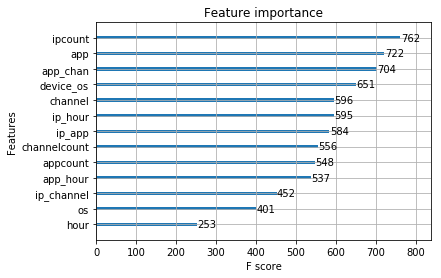

In [25]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plot_importance(model)
plt.gcf().savefig('feature_importance_xgb.png')

In [26]:
fscore=pd.Series(model.get_fscore()).sort_values(ascending = False)
print fscore

ipcount         762
app             722
app_chan        704
device_os       651
channel         596
ip_hour         595
ip_app          584
channelcount    556
appcount        548
app_hour        537
ip_channel      452
os              401
hour            253
dtype: int64


In [27]:
mean_result = reduce(lambda x, y: x + y, valid_result)/len(valid_result)
print mean_result

0.9762596


In [28]:
sub = pd.DataFrame()
sub['click_id'] = test['click_id']
test.drop('click_id', axis=1, inplace=True)

print('[{}] Start XGBoost Test'.format(time.time() - start_time))

[36966.655468] Start XGBoost Test


In [29]:
# deal with the test data
test=merge_feature(test)
test.drop(['click_time','datetime','ip','device'], axis=1, inplace=True)
test.head()

feature: ipcount 
feature: appcount
feature: channelcount 
feature ip_hour(ip+time feature)
feature app_hour
feature ip_app 
feature ip_chan
feature app_channel 
feature device_os 


,app,os,channel,hour,ipcount,appcount,channelcount,ip_hour,app_hour,ip_app,ip_channel,app_chan,device_os
0,9,3,107,4,91,2872176,1214650,34,475418,28,4,269116,274027
1,9,3,466,4,2083,2872176,422089,403,475418,289,38,372406,274027
2,21,19,128,4,2135,704267,521176,229,77207,312,158,219966,4213376
3,15,13,111,4,1201,1079113,67038,239,209436,42,2,67038,3759710
4,12,13,328,4,208,2306083,191986,60,396028,24,2,191986,3759710


In [30]:
sub['is_attributed'] = model.predict(xgb.DMatrix(test), ntree_limit=model.best_ntree_limit)
sub.to_csv('xgb_sub.csv',index=False)